In [199]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [200]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [201]:
Features=pd.read_csv("../data/data_proccesed.csv")
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

#Y -= 1

# encoder = OneHotEncoder()
# Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

In [202]:
GOAL=0.80
# zrobiłem testy przy użyciu optuna i wyszło mi coś takiego
# [I 2024-05-10 01:57:23,457] Trial 0 finished with value: 0.8076564073562622 and parameters: {'num_neurons_dense': 116, 'num_neurons_conv_1': 152, 'num_neurons_conv_2': 290, 'num_neurons_conv_3': 502, 'dropout_rate': 0.14453792383769373, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 0 with value: 0.8076564073562622.
def custom_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.02))
scheduler = LearningRateScheduler(custom_scheduler)

model_save = ModelCheckpoint(r"../model/best_model.h5",
                              save_best_only=True,
                             mode='max',
                             monitor='val_accuracy',
                             initial_value_threshold=GOAL,
                             verbose=1)

normalizer = layers.Normalization()
normalizer.adapt(X)

k=6
model = models.Sequential([
    layers.Input(shape=(x_train.shape[1],)), 
    normalizer,
    layers.Reshape((x_train.shape[1], 1)), 
    layers.Conv1D(152, 1, activation='relu'),
    layers.Conv1D(290, 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(502, 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(116, activation='relu'),
    layers.Dense(9, activation='softmax'),
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [203]:
history=model.fit(x_train, y_train, epochs=80, batch_size=64, validation_data=(x_test, y_test),callbacks=[scheduler,model_save])

Epoch 1/80
47/53 [=========================>....] - ETA: 0s - loss: 1.1526 - accuracy: 0.6067
Epoch 1: val_accuracy did not improve from 0.80000
53/53 [==============================] - 1s 11ms/step - loss: 1.1217 - accuracy: 0.6173 - val_loss: 0.8366 - val_accuracy: 0.7099 - lr: 0.0010
Epoch 2/80
43/53 [=======================>......] - ETA: 0s - loss: 0.7215 - accuracy: 0.7416
Epoch 2: val_accuracy did not improve from 0.80000
53/53 [==============================] - 0s 5ms/step - loss: 0.7160 - accuracy: 0.7435 - val_loss: 0.7805 - val_accuracy: 0.7252 - lr: 0.0010
Epoch 3/80
44/53 [=======================>......] - ETA: 0s - loss: 0.6413 - accuracy: 0.7642
Epoch 3: val_accuracy did not improve from 0.80000
53/53 [==============================] - 0s 5ms/step - loss: 0.6469 - accuracy: 0.7612 - val_loss: 0.7295 - val_accuracy: 0.7182 - lr: 0.0010
Epoch 4/80
42/53 [======================>.......] - ETA: 0s - loss: 0.5870 - accuracy: 0.7805
Epoch 4: val_accuracy did not improve from 0

In [204]:
model.save(r"../model/model.h5")
model.evaluate(x_test,y_test)

27/27 [==============================] - 0s 2ms/step - loss: 2.6879 - accuracy: 0.7642


[2.687927722930908, 0.7641509175300598]

In [205]:
try:
    best_model = tf.keras.models.load_model(r'../model/best_model.h5')
    best_model.evaluate(x_test,y_test)
except:
    print("Nie udało sie osiąganć "+str(GOAL*100)+"% accuracy")

Nie udało sie osiąganć80.0% accuracy


In [206]:
current_best_model = tf.keras.models.load_model(r'../model/current_best_model.h5')
current_best_model.evaluate(x_test,y_test)

27/27 [==============================] - 0s 2ms/step - loss: 1.9413 - accuracy: 0.8031


[1.9412624835968018, 0.8030660152435303]

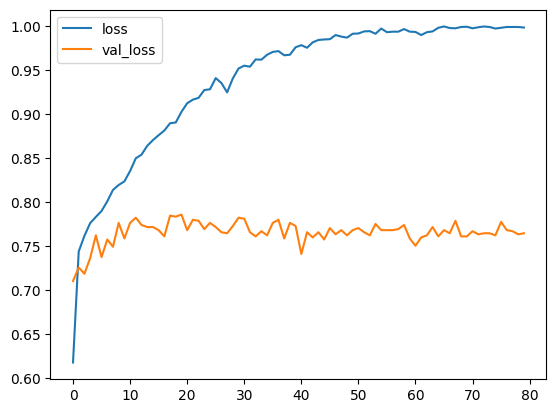

In [207]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['loss', 'val_loss'])
plt.show()

27/27 [==============================] - 0s 1ms/step
Test set accuracy: 76%


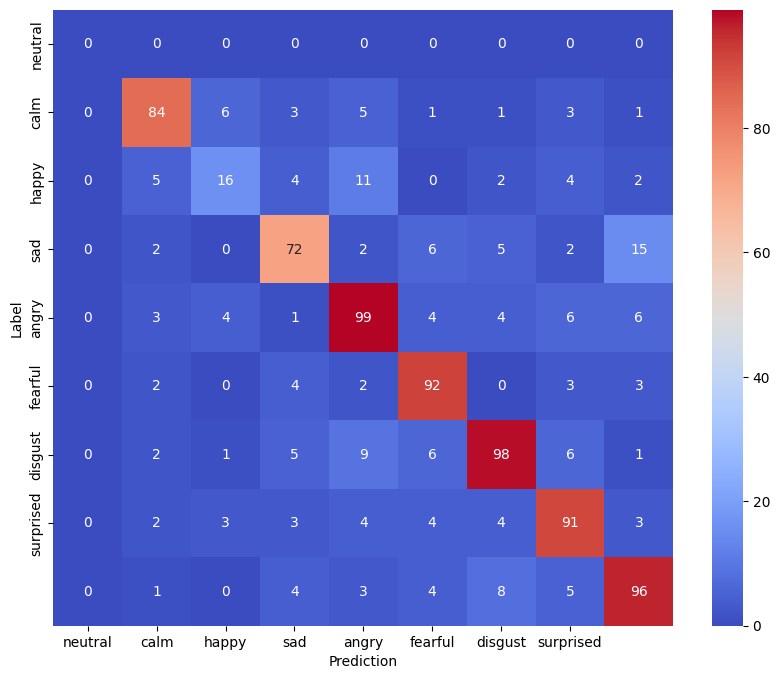

In [208]:
commands=["neutral","calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [209]:
model.evaluate(x_test,y_test)

27/27 [==============================] - 0s 2ms/step - loss: 2.6879 - accuracy: 0.7642


[2.687927722930908, 0.7641509175300598]